In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# -----------------------------------------------------------
# 1. Define Hilbert space (position x qubit)
# -----------------------------------------------------------

def bits_needed(k: int) -> int:
    """Smallest n such that 2^n >= k."""
    return int(np.ceil(np.log2(k)))

def hilbert_dims(L: int):
    """Return M (positions), n_pos, total_dimension."""
    n_pos = bits_needed(2*L + 1)
    M = 2**n_pos
    dim = M * 2      # times coin dimension
    return M, n_pos, dim



In [4]:
# -----------------------------------------------------------
# 2. Hadamard operator on the FULL space: I_pos x H_coin
# -----------------------------------------------------------

def hadamard_full(L: int):
    M, _, _ = hilbert_dims(L)
    H = (1/np.sqrt(2))*np.array([[1, 1],
                                 [1,-1]], dtype=complex)
    return np.kron(np.eye(M, dtype=complex), H)

In [5]:
# -----------------------------------------------------------
# 3. Shift operator on FULL space
# -----------------------------------------------------------

def shift_operator(L: int):
    M, _, dim = hilbert_dims(L)
    U = np.zeros((dim, dim), dtype=complex)

    for p in range(M):
        # coin = 0 → left
        in0  = p*2 + 0
        pL   = (p - 1) % M
        out0 = pL*2 + 0
        U[out0, in0] = 1

        # coin = 1 → right
        in1  = p*2 + 1
        pR   = (p + 1) % M
        out1 = pR*2 + 1
        U[out1, in1] = 1

    return U


In [6]:
# -----------------------------------------------------------
# 4. Full one-step operator: U = S (I x H)
# -----------------------------------------------------------

def walk_operator(L: int):
    H = hadamard_full(L)
    S = shift_operator(L)
    return S @ H   # matrix multiplication


In [7]:
# -----------------------------------------------------------
# Helper: encode/decode positions
# -----------------------------------------------------------

def encode_position(x: int, L: int) -> int:
    M, _, _ = hilbert_dims(L)
    offset = M // 2
    return (x + offset) % M

def decode_position(p: int, L: int) -> int:
    M, _, _ = hilbert_dims(L)
    offset = M // 2
    return p - offset

In [8]:
# -----------------------------------------------------------
# Create basis state |x> x |coin>
# -----------------------------------------------------------

def initial_state(L: int, x0: int = 0, coin_state=(1,0)):
    """
    Prepare |x0> ⊗ (alpha|0> + beta|1>), where coin_state = (alpha, beta)
    Alpha and beta may be complex.
    """
    M, _, dim = hilbert_dims(L)
    alpha, beta = coin_state

    # Normalize the coin
    norm = np.sqrt(abs(alpha)**2 + abs(beta)**2)
    alpha /= norm
    beta  /= norm

    psi = np.zeros(dim, dtype=complex)

    # Encode position
    p = encode_position(x0, L)

    psi[p*2 + 0] = alpha
    psi[p*2 + 1] = beta

    return psi

In [9]:
# -----------------------------------------------------------
# 5. Run the walk for T steps and compute RMS distance
# -----------------------------------------------------------

def run_walk(L: int, T: int, x0: int = 0, coin_state=(1,0)):
    U = walk_operator(L)
    psi = initial_state(L, x0, coin_state)

    M, _, _ = hilbert_dims(L)
    xs = np.array([decode_position(p, L) for p in range(M)])

    rms = []

    def rms_from_state(v):
        v2 = v.reshape(M,2)
        probs = np.sum(np.abs(v2)**2, axis=1)
        return np.sqrt(np.sum(xs**2 * probs))

    # t=0
    rms.append(rms_from_state(psi))

    # evolve for T steps
    for _ in range(T):
        psi = U @ psi
        rms.append(rms_from_state(psi))

    return psi, np.array(rms), xs

In [10]:
def plot_position_distribution(psi, L, title="Position Probabilities"):
    M = 2**int(np.ceil(np.log2(2*L+1)))
    v2 = psi.reshape(M,2)
    probs = np.sum(np.abs(v2)**2, axis=1)
    xs = np.arange(M) - (M//2)

    plt.figure(figsize=(7,4))
    plt.bar(xs, probs, width=0.8)
    plt.xlabel("Position x")
    plt.ylabel("Probability")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [11]:
def get_position_amplitudes(psi, L):
    M = 2**int(np.ceil(np.log2(2*L+1)))
    psi2 = psi.reshape(M,2)
    amp = np.sum(psi2, axis=1)   # coin-marginalized amplitude
    xs = np.arange(M) - (M//2)
    return xs, amp

In [12]:
def plot_real_amplitudes(psi, L, title="Re[ψ(x)]"):
    xs, amp = get_position_amplitudes(psi, L)
    plt.figure(figsize=(7,4))
    plt.stem(xs, np.real(amp))
    plt.xlabel("x")
    plt.ylabel("Re ψ")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [13]:
def plot_imag_amplitudes(psi, L, title="Im[ψ(x)]"):
    xs, amp = get_position_amplitudes(psi, L)
    plt.figure(figsize=(7,4))
    plt.stem(xs, np.imag(amp))
    plt.xlabel("x")
    plt.ylabel("Im ψ")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [14]:
def plot_magnitude(psi, L, title="|ψ(x)|"):
    xs, amp = get_position_amplitudes(psi, L)
    plt.figure(figsize=(7,4))
    plt.stem(xs, np.abs(amp))
    plt.xlabel("x")
    plt.ylabel("|ψ|")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()


In [15]:
def plot_phase(psi, L, title="arg(ψ(x))"):
    xs, amp = get_position_amplitudes(psi, L)
    plt.figure(figsize=(7,4))
    plt.stem(xs, np.angle(amp))
    plt.xlabel("x")
    plt.ylabel("Phase (rad)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [16]:
L = 40
T = 30

alpha = 1/np.sqrt(3)
beta  = np.sqrt(2/3) * 1j

psi_final, rms_vals, xs = run_walk(
    L=L,
    T=T,
    x0=0,
    coin_state=(alpha, beta)
)


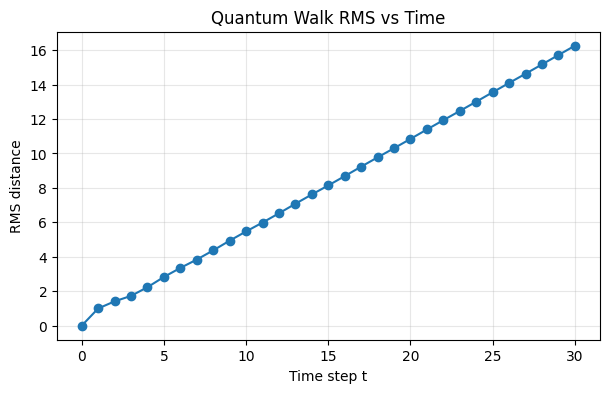

In [19]:
# --- Plot RMS vs time ---
plt.figure(figsize=(7,4))
plt.plot(range(T+1), rms_vals, marker="o")
plt.xlabel("Time step t")
plt.ylabel("RMS distance")
plt.title("Quantum Walk RMS vs Time")
plt.grid(True, alpha=0.3)
plt.show()

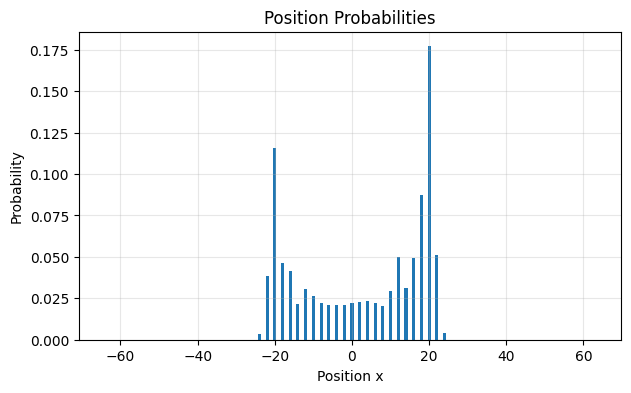

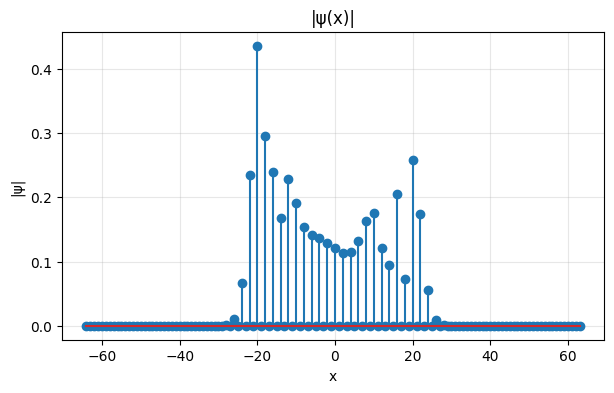

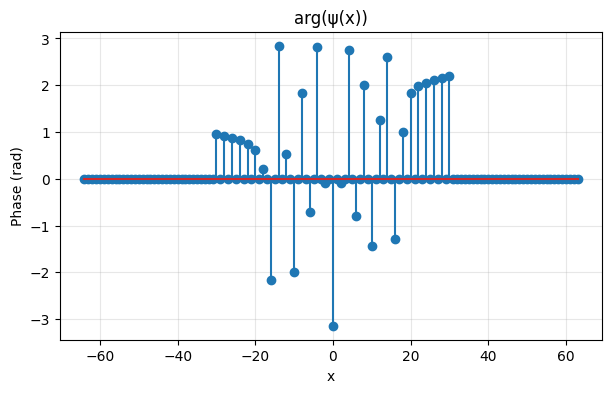

In [20]:
plot_position_distribution(psi_final, L)
plot_magnitude(psi_final, L)
plot_phase(psi_final, L)
